In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Text(0,0.5,u'$y$')

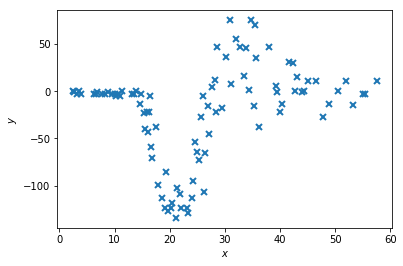

In [2]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [3]:
#build the model
k1 = hetero_kernels.RBF(1)
k2 = hetero_kernels.RBF(1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptLAdaptN(Xnorm, Y[:,None], k1, k2, nonstat)

In [4]:
m

Name,values,prior,constraint
adapt_ll_noise_gps.V1,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V2,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V3,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.kern1.lengthscales,[ 1.],None,+ve
adapt_ll_noise_gps.kern1.variance,[ 1.],None,+ve
adapt_ll_noise_gps.kern2.lengthscales,[ 1.],None,+ve
adapt_ll_noise_gps.kern2.variance,[ 1.],None,+ve
adapt_ll_noise_gps.nonstat.signal_variance,[ 1.],None,+ve
adapt_ll_noise_gps.signal_variance,[ 1.],None,+ve


In [5]:
m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern1.variance = 0.1
m.kern1.variance.fixed = True
#m.kern1.variance.prior = gpflow.priors.Gamma(1., 1.)

m.kern2.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern2.variance = 0.1
m.kern2.variance.fixed = True

m.nonstat.signal_variance = 100
m.nonstat.signal_variance.fixed = True

In [6]:
m.optimize(maxiter=5000)

      fun: array([ 778.50576127])
 hess_inv: <285x285 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.27782661e-05,   1.37343402e-03,   4.91790047e-04,
         2.12988075e-04,  -1.37870849e-04,   3.91665882e-04,
        -3.06942576e-04,  -1.76467109e-04,  -4.08065648e-04,
        -5.19859656e-04,  -5.30991468e-04,   1.77992303e-04,
        -4.47192539e-04,  -5.58009483e-05,  -1.50725591e-04,
         8.53981998e-05,  -2.67742395e-04,  -1.47537689e-04,
        -1.39061273e-04,   2.50362084e-04,   4.49905089e-04,
        -1.36618618e-03,  -1.89249706e-05,   6.06980321e-06,
        -1.79038212e-04,  -1.93922484e-04,  -1.36219391e-04,
        -1.08224983e-04,  -9.23273237e-05,  -6.27228047e-05,
        -1.01434371e-04,  -8.38063043e-05,  -1.19260830e-04,
        -1.05126247e-04,  -6.01197574e-05,  -5.07885364e-05,
        -9.62615549e-05,  -6.62519799e-05,  -9.20155773e-05,
        -6.49600543e-05,  -4.90801054e-05,  -4.22371872e-05,
        -7.82222540e-05,  -3.55633646e-05

In [7]:
samples = m.sample(2000, verbose=True, epsilon=0.01, thin = 2, burn = 1000, Lmax = 40)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  99.0 %
Iteration:  600 	 Acc Rate:  100.0 %
Iteration:  700 	 Acc Rate:  100.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  100.0 %
Iteration:  1000 	 Acc Rate:  100.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  100.0 %
Iteration:  600 	 Acc Rate:  100.0 %
Iteration:  700 	 Acc Rate:  100.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  100.0 %
Iteration:  1000 	 Acc Rate:  100.0 %
Iteration:  1100 	 Acc Rate:  99.0 %
Iteration:  1200 	 Acc Rate:  100.0 %
Iteration:  1300 	 Acc Rate:  100.0 %
Iteration:  1400 	 Acc Rate:  100.0 %
Iteration:  1500 	 Acc Rate:  100.0 %
Iteration:  1600 	 Acc Ra

In [8]:
m

Name,values,prior,constraint
adapt_ll_noise_gps.V1,[[ -3.18370139e+00] [ -1.44943325e+00] [ -9.35807351e-01] [ -2.67965371e-01] [ -2.23821506e-01] [ -6.42887338e-01] [ -2.49243251e-01] [ -1.86175181e-01] [ -3.66224591e-01] [ -2.36290428e-01] [ -2.12516382e-01] [ -1.99868593e-01] [ -1.38641569e-01] [ -9.95486484e-02] [ -1.01897517e-01] [ -1.03249214e-01] [ -1.07010180e-01] [ -2.21176692e-01] [ -1.30408152e-01] [ -9.12399670e-02] [ -1.20564276e-01] [ -9.52563327e-02] [ -1.06055725e-01] [ -8.28731712e-02] [ -7.68643203e-02] [ -6.79191037e-02] [ -6.82152303e-02] [ -6.76485135e-02] [ -5.93042325e-02] [ -5.80120369e-02] [ -9.41496614e-02] [ -7.30357446e-02] [ -9.07284944e-02] [ -8.35658212e-02] [ -6.14650427e-02] [ -5.02860505e-02] [ -5.71236173e-02] [ -4.71997781e-02] [ -6.04053433e-02] [ -4.78018304e-02] [ -4.71327125e-02] [ -4.08483416e-02] [ -6.68517234e-02] [ -4.93276589e-02] [ -5.19402319e-02] [ -4.19661938e-02] [ -4.22171792e-02] [ -4.16383092e-02] [ -4.10345380e-02] [ -3.64308521e-02] [ -3.80257397e-02] [ -3.15853275e-02] [ -3.01095922e-02] [ -3.81177787e-02] [ -3.23922339e-02] [ -3.42458892e-02] [ -3.77123691e-02] [ -3.03700214e-02] [ -2.79469547e-02] [ -3.29005803e-02] [ -3.62186768e-02] [ -3.51150893e-02] [ -2.39195025e-02] [ -2.64229993e-02] [ -2.59682526e-02] [ -2.25903329e-02] [ -1.90577979e-02] [ -1.86047918e-02] [ -1.66849823e-02] [ -1.53863809e-02] [ -1.29244981e-02] [ -1.15761066e-02] [ -1.41479339e-02] [ -2.37293128e-02] [ -2.11949251e-02] [ -1.27103477e-02] [ -1.15929650e-02] [ -9.57901108e-03] [ -1.14809386e-02] [ -1.03795057e-02] [ -8.15346127e-03] [ -6.14579137e-03] [ -7.62675332e-03] [ -6.23213922e-03] [ -5.83684549e-03] [ -7.42189405e-03] [ -6.98865701e-03] [ -4.69309007e-03] [ -3.53628066e-03] [ -1.85802542e-03] [ -4.42244852e-03] [ -1.70719042e-03] [ -8.79107368e-04] [ -7.04773888e-04]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V2,[[ 3.09753241e+00] [ 6.17943366e+00] [ 2.88450296e+00] [ 1.44324710e+00] [ 1.94885615e+00] [ 5.21767201e+00] [ 1.35379861e+00] [ 1.02649045e+00] [ 2.19689187e+00] [ 1.35370070e+00] [ 1.40223746e+00] [ 1.60727498e+00] [ 1.19495941e+00] [ 8.96797302e-01] [ 1.04533330e+00] [ 1.12342696e+00] [ 1.13320804e+00] [ 2.01902804e+00] [ 8.37240407e-01] [ 5.58414969e-01] [ 8.42816054e-01] [ 5.94638545e-01] [ 7.43290368e-01] [ 5.68987269e-01] [ 4.97723519e-01] [ 4.66326162e-01] [ 4.53860806e-01] [ 4.52603392e-01] [ 4.46175518e-01] [ 4.46916907e-01] [ 7.53957581e-01] [ 5.65577754e-01] [ 7.30261251e-01] [ 6.55291286e-01] [ 4.46356401e-01] [ 3.73471393e-01] [ 4.85080637e-01] [ 3.90315705e-01] [ 5.64402498e-01] [ 4.06383294e-01] [ 4.07132594e-01] [ 3.40415815e-01] [ 6.11583291e-01] [ 3.77913587e-01] [ 4.01331536e-01] [ 2.99508668e-01] [ 3.08335650e-01] [ 3.15303423e-01] [ 3.19143938e-01] [ 2.68607262e-01] [ 2.93797747e-01] [ 2.59392883e-01] [ 2.34483567e-01] [ 3.17483157e-01] [ 2.63450822e-01] [ 2.77317571e-01] [ 3.20814243e-01] [ 2.47776462e-01] [ 2.13968607e-01] [ 3.00959069e-01] [ 3.25710458e-01] [ 3.09183898e-01] [ 1.94820787e-01] [ 2.39515932e-01] [ 2.47833123e-01] [ 2.13495200e-01] [ 1.73683491e-01] [ 1.79354494e-01] [ 1.58800768e-01] [ 1.43736549e-01] [ 1.18194201e-01] [ 1.01405061e-01] [ 1.35977062e-01] [ 2.31904972e-01] [ 1.60578487e-01] [ 8.02473862e-02] [ 8.27067874e-02] [ 7.16396972e-02] [ 1.06059086e-01] [ 8.67794811e-02] [ 5.81651903e-02] [ 4.22758613e-02] [ 5.86742811e-02] [ 4.37055235e-02] [ 4.13864046e-02] [ 5.30274354e-02] [ 3.76460076e-02] [ 2.14000055e-02] [ 1.98076906e-02] [ 1.38233410e-02] [ 6.52639361e-03] [ 1.75614716e-03] [ 1.01571023e-03] [ 2.35007465e-03]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V3,[[ -8.47838788e-02] [ -2.71110811e-01] [ -1.94346876e-01] [ -1.99760853e-02] [ 7.54696273e-02] [ 3.00651826e-01] [ 2.76809435e-01] [ 2.05682758e-02] [ -1.24416690e-01] [ -7.18269917e-01] [ -9.16376726e-01] [ -1.58672402e+00] [ -1.93936806e+00] [ -1.29923754e+00] [ -1.93284152e+00] [ -2.06011339e+00] [ -2.26633711e+00] [ -3.91850747e+00] [ -3.62721494e+00] [ -1.49684965e+00

In [9]:
xnew = np.linspace(0,60,50)[:,None]
xx = (xnew - Xm)/Xv

In [10]:
sample_df = m.get_samples_df(samples)

In [11]:
mean_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [12]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_l(xx)
    var1 = v1[:,:]
    mean_l_mat[i,:] = mean1[:,0]
    var_l_mat[i,:] = np.diag(var1)

std_l_mat = np.sqrt(var_l_mat)

In [13]:
LowerlogL = mean_l_mat - 2*std_l_mat
UpperlogL = mean_l_mat + 2*std_l_mat

In [14]:
MeanL = np.exp(mean_l_mat)
LowerL = np.exp(LowerlogL)
UpperL = np.exp(UpperlogL)

In [15]:
def visualize(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

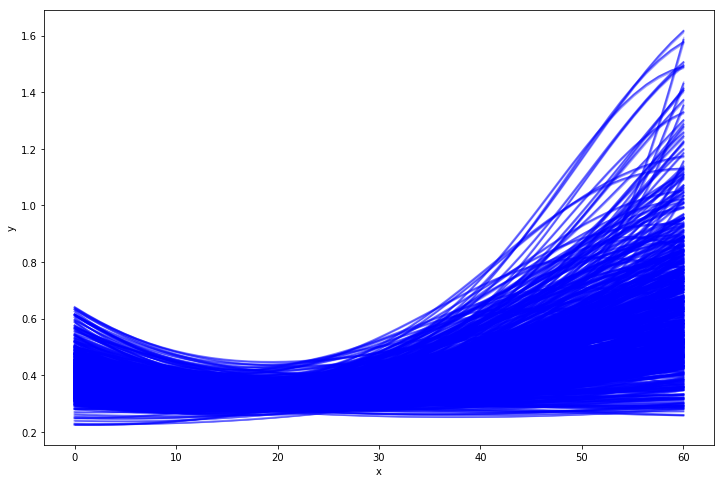

In [16]:
mini = 505
maxi = 1110
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

In [17]:
mean_n_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_n_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [18]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_n(xx)
    var1 = v1[:,:]
    mean_n_mat[i,:] = mean1[:,0]
    var_n_mat[i,:] = np.diag(var1)

std_n_mat = np.sqrt(var_n_mat)

In [19]:
LowerlogN = mean_n_mat - 2*std_n_mat
UpperlogN = mean_n_mat + 2*std_n_mat

In [20]:
MeanN = np.exp(mean_n_mat)
LowerN = np.exp(LowerlogN)
UpperN = np.exp(UpperlogN)

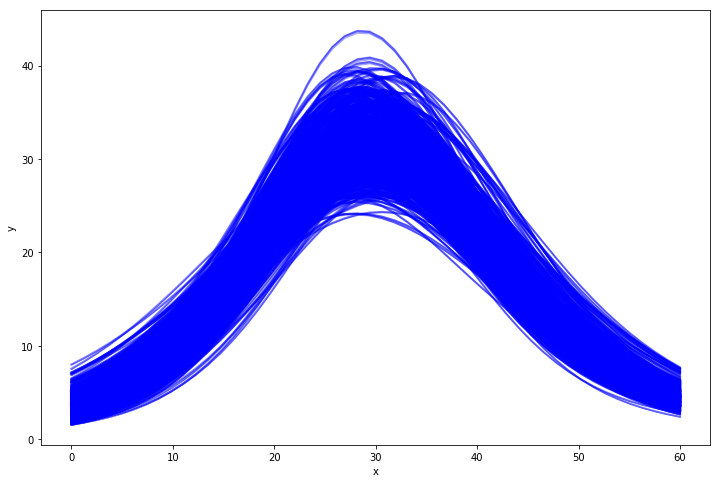

In [21]:
mini = 500
maxi = 1110
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, MeanN[i,:], LowerN[i,:], UpperN[i,:])  

In [22]:
sig_samples = m.signal_variance.get_samples_df(samples)
signal_var = np.array([])
for s in sig_samples:
    signal_var = np.append(signal_var, s)

In [23]:
mean_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_f(xx)
    var1 = v1[:,:]
    mean_f_mat[i,:] = mean1[:,0]
    var_f_mat[i,:] = np.diag(var1)    

In [24]:
std_f_mat = np.sqrt(var_f_mat)

In [25]:
Lowerf = mean_f_mat - 2*std_f_mat
Upperf = mean_f_mat + 2*std_f_mat

In [33]:
def visualize_all(Xgrid, M1, L1, U1, U2, signal_var):
    """
    Visualize
    """  
    L2 = L1 - U2
    U2 = U1 + U2
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, M1, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L1, U1,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], L2, U2,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

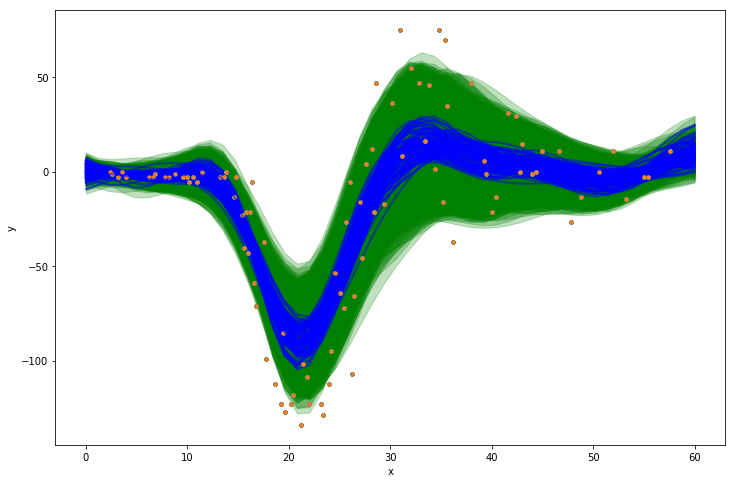

In [34]:
mini = 500
maxi = 602
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_all(xnew, mean_f_mat[i,:],
              Lowerf[i,:], Upperf[i,:],
              UpperN[i,:], signal_var[i])